In [1]:
import pandas as pd
import numpy as np
from scipy.stats import kruskal
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import seaborn as sns
from utils.ci import bootstrap_ci
from utils.visulize import plot_grouped_bar_with_ci
from utils.grouping import get_group_labels

In [2]:
# load data
df = pd.read_csv('./summary_results.csv')
dataset_name = "CF"  # Change to 'CF', 'CON', etc., for other comparisons
df = df[df['dataset'] == dataset_name].copy()

# ensure df has 240 rows excluding the title row
assert df.shape[0] == 240, f"Expected 240 rows, but got {df.shape[0]} rows."

In [3]:
print(df.columns)
metric_names = ['accuracy', 'f1_score', 'precision', 'recall', 'roc_auc']
models = df['model'].unique()

Index(['dataset', 'seed', 'model', 'accuracy', 'f1_score', 'precision',
       'recall', 'roc_auc'],
      dtype='object')



===== ACCURACY =====
Kruskal-Wallis: H = 170.083, p = 0.0000

Post-hoc Dunn’s test (Holm-corrected):
                      logistic          lstm  lstm-features       lstmfcn  \
logistic          1.000000e+00  5.605470e-02   1.761212e-08  2.901539e-01   
lstm              5.605470e-02  1.000000e+00   8.250455e-03  1.000000e+00   
lstm-features     1.761212e-08  8.250455e-03   1.000000e+00  7.425031e-04   
lstmfcn           2.901539e-01  1.000000e+00   7.425031e-04  1.000000e+00   
lstmfcn-features  1.772579e-02  1.000000e+00   3.246754e-02  1.000000e+00   
randomforest      2.901539e-01  2.806428e-05   5.827610e-15  5.309515e-04   
svm               3.744106e-02  3.512011e-07   3.831132e-18  1.070909e-05   
vivit             8.970877e-04  3.994789e-10   9.360429e-23  2.466034e-08   

                  lstmfcn-features  randomforest           svm         vivit  
logistic              1.772579e-02  2.901539e-01  3.744106e-02  8.970877e-04  
lstm                  1.000000e+00  2.806428e-

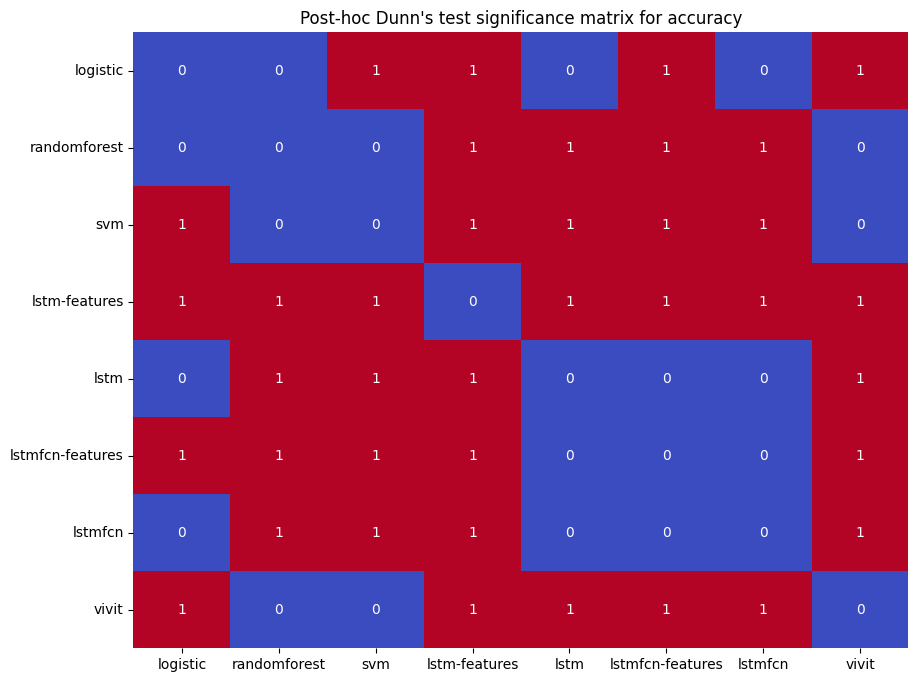

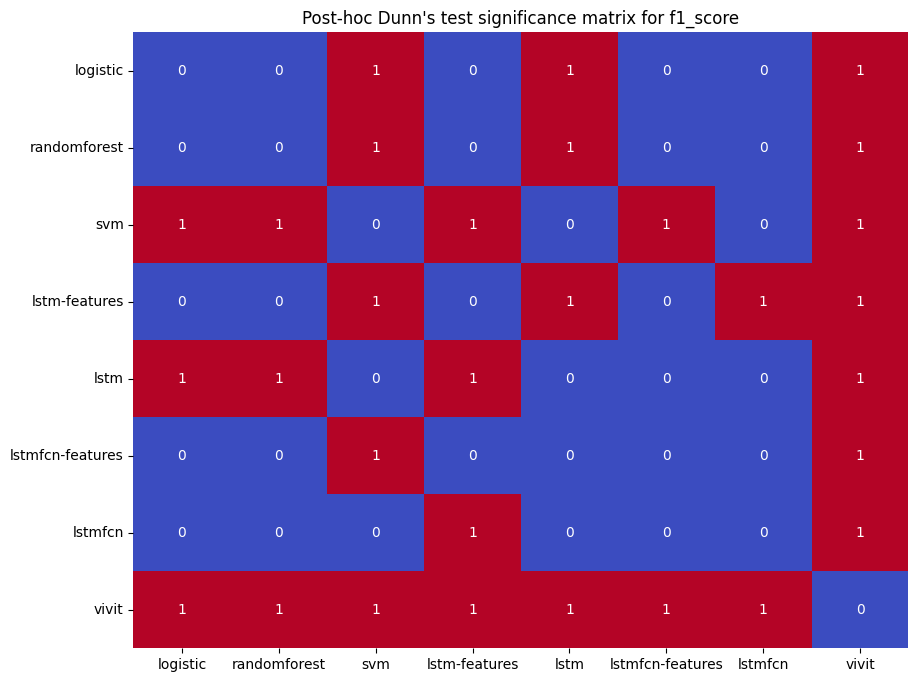

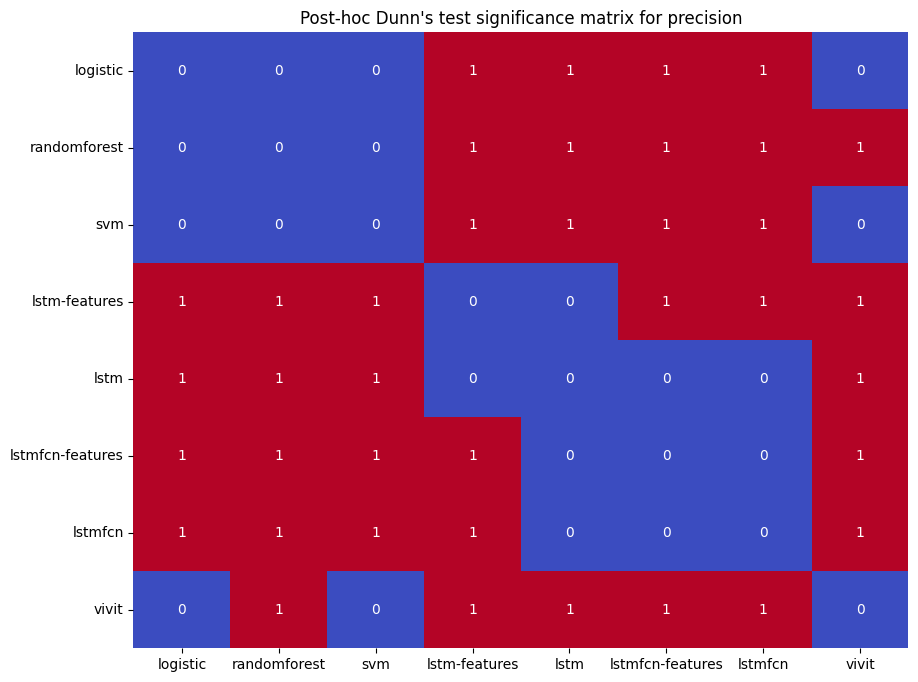

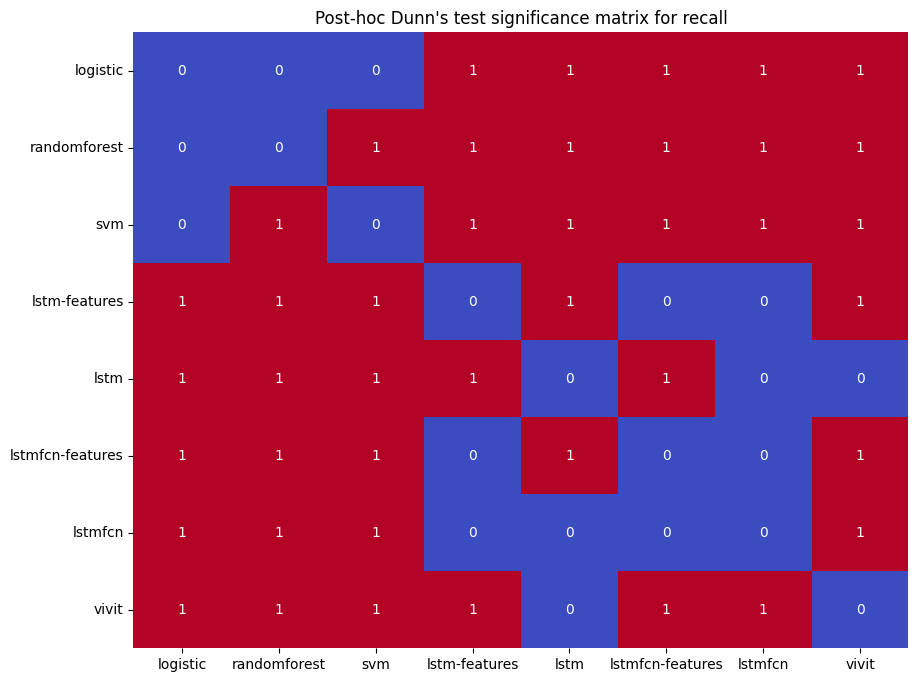

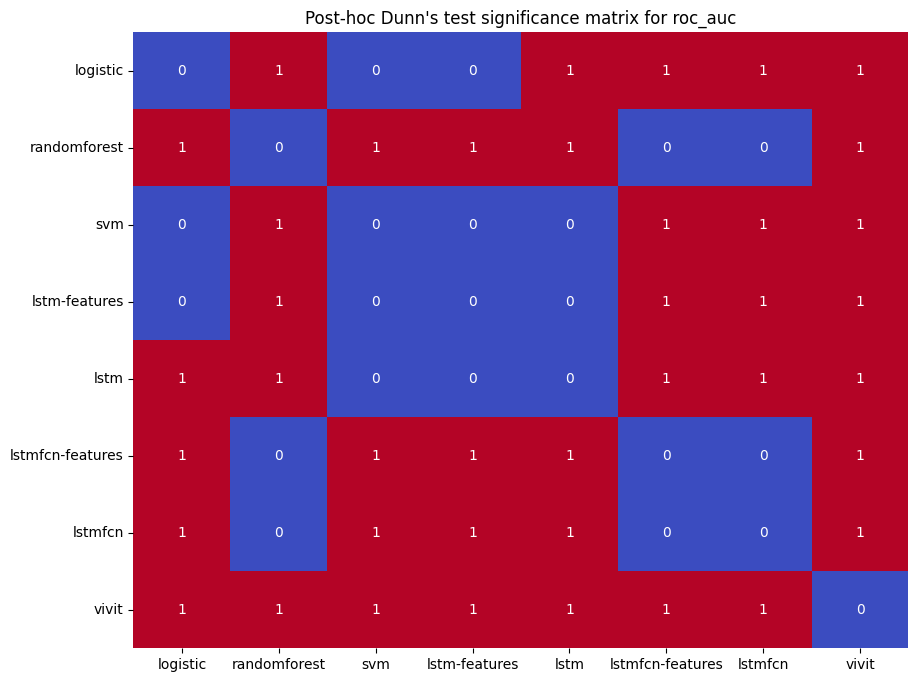

In [4]:
# Run analysis per metric
posthoc_results = {}
for metric in metric_names:
    print(f"\n===== {metric.upper()} =====")
    data_by_model = [df[df['model'] == m][metric] for m in models]

    # Kruskal-Wallis test
    H, p = kruskal(*data_by_model)
    print(f"Kruskal-Wallis: H = {H:.3f}, p = {p:.4f}")
    
    # Post-hoc test if significant
    if p < 0.05:
        posthoc = sp.posthoc_dunn(df, val_col=metric, group_col='model', p_adjust='holm')
        posthoc_results[metric] = posthoc
        print("\nPost-hoc Dunn’s test (Holm-corrected):")
        print(posthoc)

        sig_plot = posthoc.apply(lambda x: x < 0.05).astype(int)
        # Plotting the significance matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(sig_plot.loc[models, models], annot=True, cmap='coolwarm', cbar=False)
        plt.title(f"Post-hoc Dunn's test significance matrix for {metric}")
    else:
        print("No statistically significant difference among models.")

In [5]:
group_labels_per_metric = get_group_labels(posthoc_results, alpha=0.05)
print(group_labels_per_metric)


{'accuracy': {'logistic': 'A', 'lstm': 'A', 'lstmfcn': 'A', 'lstmfcn-features': 'B', 'randomforest': 'C', 'svm': 'C', 'vivit': 'C', 'lstm-features': 'D'}, 'f1_score': {'logistic': 'A', 'lstmfcn': 'A', 'lstmfcn-features': 'A', 'randomforest': 'A', 'lstm-features': 'B', 'lstm': 'C', 'svm': 'D', 'vivit': 'E'}, 'precision': {'lstm': 'A', 'lstmfcn': 'A', 'lstmfcn-features': 'A', 'logistic': 'B', 'svm': 'B', 'vivit': 'B', 'randomforest': 'C', 'lstm-features': 'D'}, 'recall': {'lstm-features': 'A', 'lstmfcn': 'A', 'lstmfcn-features': 'A', 'lstm': 'B', 'vivit': 'B', 'logistic': 'C', 'svm': 'C', 'randomforest': 'D'}, 'roc_auc': {'logistic': 'A', 'lstm-features': 'A', 'svm': 'A', 'lstm': 'B', 'lstmfcn': 'C', 'lstmfcn-features': 'C', 'randomforest': 'C', 'vivit': 'D'}}


Model: logistic, Metric: accuracy, Mean: 0.7166666666666667, CI: [0.7119047619047618, 0.7214285714285713]
Model: randomforest, Metric: accuracy, Mean: 0.7049999999999998, CI: [0.7002380952380952, 0.7095238095238094]
Model: svm, Metric: accuracy, Mean: 0.6992857142857141, CI: [0.6945238095238097, 0.7045238095238092]
Model: lstm, Metric: accuracy, Mean: 0.7304761904761906, CI: [0.727857142857143, 0.7330952380952382]
Model: lstm-features, Metric: accuracy, Mean: 0.7504761904761904, CI: [0.7473809523809524, 0.7535714285714286]
Model: lstmfcn, Metric: accuracy, Mean: 0.7273809523809526, CI: [0.7235714285714286, 0.7311904761904761]
Model: lstmfcn-features, Metric: accuracy, Mean: 0.7326190476190477, CI: [0.7288095238095238, 0.7364285714285715]
Model: vivit, Metric: accuracy, Mean: 0.685238095238095, CI: [0.6764285714285714, 0.6931011904761905]
Model: logistic, Metric: f1_score, Mean: 0.7455203432774871, CI: [0.7412529090413936, 0.7494929142740746]
Model: randomforest, Metric: f1_score, Mean:

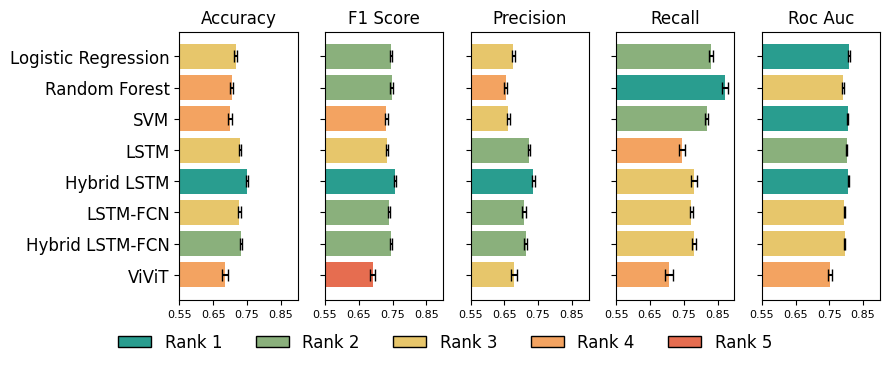

In [6]:
plot_grouped_bar_with_ci(models, df, group_labels_per_metric, 'Cabernet Franc')

In [7]:
# change the col and row names to these model names
model_names = {
    'logistic': 'Logistic Regression',
    'randomforest': 'Random Forest',
    'svm': 'SVM',
    'lstm-features': 'Hybrid LSTM',
    'lstm': 'LSTM',
    'lstmfcn-features': 'Hybrid LSTM-FCN',
    'lstmfcn': 'LSTM-FCN',
    'vivit': 'ViVit',
}
# set the ordering for the col and row names
model_order = [
    'logistic',
    'randomforest',
    'svm',
    'lstm',
    'lstm-features',
    'lstmfcn',
    'lstmfcn-features',
    'vivit',
]

# for all values in posthoc_results, only remain 3 digits
# e.g. 0.123456 -> 0.123; 1.0 -> 1.00; 0.01123121e-05 -> 0.01e-05； 1 -> 1.00
# store each metric's posthoc result to a csv file
def fmt_three_digits(x):
    # Leave non-numerics (e.g., "ns", "-") alone
    if isinstance(x, (np.integer, int, np.floating, float)):
        s = f"{float(x):.3g}"  # 3 significant digits; uses sci-notation when appropriate
        # If not scientific and no decimal point, pad to .00 (e.g., 1 -> 1.00)
        if 'e' not in s and '.' not in s:
            s = s + '.00'
        return s
    return x


for metric, df in posthoc_results.items():
    # 1) format numbers
    df = df.applymap(fmt_three_digits)

    # 2) rename rows/cols to pretty names
    df = df.rename(index=model_names, columns=model_names)

    # 3) order rows/cols safely (keep only those present)
    desired_idx = [model_names[m] for m in model_order if model_names.get(m) in df.index]
    desired_cols = [model_names[m] for m in model_order if model_names.get(m) in df.columns]
    df = df.loc[desired_idx, desired_cols]

    # 4) save
    df.to_csv(f'./tables/posthoc_dunn_{dataset_name}_{metric}.csv')

C:\Users\Mud\AppData\Local\Temp\ipykernel_44752\631486915.py:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(fmt_three_digits)
C:\Users\Mud\AppData\Local\Temp\ipykernel_44752\631486915.py:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(fmt_three_digits)
C:\Users\Mud\AppData\Local\Temp\ipykernel_44752\631486915.py:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(fmt_three_digits)
C:\Users\Mud\AppData\Local\Temp\ipykernel_44752\631486915.py:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(fmt_three_digits)
C:\Users\Mud\AppData\Local\Temp\ipykernel_44752\631486915.py:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(fmt_three_digits)
